# Import Libraries

In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, association_rules
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE

# Load Datasets

In [115]:
bank_df = pd.read_csv('bank.csv', delimiter=';')

file_path = 'adult.data'
columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
    'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
    'hours-per-week', 'native-country', 'income'
]
adult_df = pd.read_csv(file_path, names=columns, na_values="?", skipinitialspace=True)

# EDA

In [116]:
def initial_data_analysis(df, target_column):
    # Display descriptive statistics
    desc_stats = df.describe()
    print("Descriptive Statistics:")
    print(desc_stats)
    
    # Visualizations
    # Histograms for all numerical features
    df.hist(bins=15, figsize=(15, 10), layout=(5, 3))
    plt.tight_layout()
    plt.show()

    # Correlation matrix heatmap
    correlation_matrix = df.corr()
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
    plt.title("Correlation Analysis")
    plt.show()

    # Correlation with target variable
    target_correlation = df.corrwith(df[target_column]).sort_values(ascending=False)
    print("\nCorrelation with target variable:")
    print(target_correlation)

    # Boxplots for categorical variables against target
    cat_cols = df.select_dtypes(include=['object', 'category']).columns
    for col in cat_cols:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x=col, y=target_column, data=df)
        plt.title(f'{col} vs {target_column}')
        plt.xticks(rotation=45)
        plt.show()

    # Returning descriptive statistics for further processing if needed
    return desc_stats, correlation_matrix, target_correlation

# Example usage:
# adult_desc_stats, adult_correlation_matrix, adult_target_correlation = initial_data_analysis(adult_df_clean, 'income')
# bank_desc_stats, bank_correlation_matrix, bank_target_correlation = initial_data_analysis(bank_df_clean, 'subscription')


# Feature Engineering

In [117]:
# Binary indicators for capital gains and losses
adult_df['positive_capital_gain'] = (adult_df['capital-gain'] > 0).astype(int)
adult_df['positive_capital_loss'] = (adult_df['capital-loss'] > 0).astype(int)

# Interaction feature between age and education-num
adult_df['age_education_interaction'] = adult_df['age'] * adult_df['education-num']

# Aggregating less common categories into 'Other'
top_occupations = adult_df['occupation'].value_counts().nlargest(5).index
adult_df['occupation_aggregated'] = adult_df['occupation'].apply(lambda x: x if x in top_occupations else 'Other')

top_countries = adult_df['native-country'].value_counts().nlargest(5).index
adult_df['native_country_aggregated'] = adult_df['native-country'].apply(lambda x: x if x in top_countries else 'Other')

# Binning age and hours-per-week
age_bins = [0, 25, 35, 45, 55, 65, 100]
age_labels = ['0-25', '26-35', '36-45', '46-55', '56-65', '66+']
adult_df['age_binned'] = pd.cut(adult_df['age'], bins=age_bins, labels=age_labels, right=False)

hours_bins = [0, 20, 30, 40, 50, 100]
hours_labels = ['0-20', '21-30', '31-40', '41-50', '51+']
adult_df['hours_per_week_binned'] = pd.cut(adult_df['hours-per-week'], bins=hours_bins, labels=hours_labels, right=False)

adult_df = adult_df.drop(['age', 'hours-per-week', 'occupation', 'native-country', 'fnlwgt'], axis=1)

In [118]:

# Aggregating less common categories into 'Other'
top_jobs = bank_df['job'].value_counts().nlargest(5).index
bank_df['job_aggregated'] = bank_df['job'].apply(lambda x: x if x in top_jobs else 'Other')

# Binning age and hours-per-week
age_bins = [0, 25, 35, 45, 55, 65, 75, 100]
age_labels = ['0-25', '26-35', '36-45', '46-55', '56-65', '66-75', '75+']
bank_df['age_binned'] = pd.cut(bank_df['age'], bins=age_bins, labels=age_labels, right=False)

bank_df = bank_df.drop(['age', 'job'], axis=1)

# Preprocessing

In [119]:
def preprocess(df, target_column=None):
    df = df.dropna()
    
    y = df[target_column] if target_column else None
    if target_column:
        df = df.drop(columns=[target_column])

    # Identify categorical columns
    cat_cols = df.select_dtypes(include=['object', 'category']).columns
    # Apply one-hot encoding
    df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)
    
    # Identify numerical columns (excluding dummy variables)
    num_cols = df_encoded.select_dtypes(include=['int64', 'float64']).columns
    
    # Standardize numerical features
    scaler = StandardScaler()
    df_encoded[num_cols] = scaler.fit_transform(df_encoded[num_cols])
    
    return (df_encoded, y) if target_column else df_encoded


# Dimensionality Reduction

In [120]:
def apply_pca(df, explained_variance_threshold=0.95):
 
    # Initialize PCA
    pca = PCA(n_components=df.shape[1])
    
    # Fit and transform the data
    principal_components = pca.fit_transform(df)
    
    # Determine the number of components to retain
    total_variance = np.cumsum(pca.explained_variance_ratio_)
    n_components = np.argmax(total_variance >= explained_variance_threshold) + 1
    
    # Re-apply PCA with the optimal number of components
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(df)
    
    # Convert to a DataFrame
    pca_df = pd.DataFrame(data=principal_components,
                          columns=[f'PC{i+1}' for i in range(n_components)])
    
    # Plot the explained variance
    plt.figure(figsize=(8, 5))
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Total Explained Variance')
    plt.axvline(x=n_components, linestyle='--', label='Optimal Components')
    plt.title('Explained Variance by PCA Components')
    plt.legend()
    plt.show()
    
    return pca_df, pca


# DBSCAN

## DBSCAN Parameter Estimation

In [121]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

def plot_k_distance(data, k):
    """
    Plot the k-distance graph for the dataset to find the optimal epsilon (elbow method).
    """
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(data)
    distances, indices = neigh.kneighbors(data)
    
    # Sort distances
    sorted_distances = np.sort(distances[:, k-1], axis=0)
    
    plt.figure(figsize=(10, 5))
    plt.plot(sorted_distances)
    plt.title("K-Distance Graph")
    plt.xlabel("Points sorted by distance")
    plt.ylabel(f"Distance to {k}-th nearest neighbor")
    plt.grid(True)
    plt.show()

    return sorted_distances

from kneed import KneeLocator

def detect_knee_point(sorted_distances):
    """
    Detect the knee point using the 'kneed' library to find the optimal epsilon.
    """
    knee_locator = KneeLocator(range(len(sorted_distances)), sorted_distances, curve='convex', direction='increasing')
    knee_point = knee_locator.knee
    
    plt.figure(figsize=(10, 5))
    plt.plot(sorted_distances)
    plt.scatter(knee_point, sorted_distances[knee_point], color='red', label='Knee point')
    plt.title("K-Distance Graph with Knee Point")
    plt.xlabel("Points")
    plt.ylabel("Distance")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return sorted_distances[knee_point]


In [122]:
def optimize_dbscan_params(data, eps_values, min_samples_values):
    """
    Perform grid search over eps and MinPts values to find the best DBSCAN clustering parameters.
    """
    best_score = -1
    best_eps = 0
    best_min_samples = 0
    best_labels = None
    best_cluster_count = 0
    total_points = data.shape[0]
    max_noise_points = total_points * 0.20  # 10% of total points as maximum allowed noise

    for eps in eps_values:
        for min_samples in min_samples_values:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(data)
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            noise_points = np.count_nonzero(labels == -1)

            if n_clusters > 1 and noise_points <= max_noise_points and n_clusters < 10 and noise_points>0:
                if -1 in labels:
                    silhouette = silhouette_score(data, labels)
                else:
                    silhouette = silhouette_score(data, labels)
                
                print(f"Testing eps={eps}, min_samples={min_samples}: silhouette={silhouette:.4f}, clusters={n_clusters}, noise={noise_points}")

                if silhouette > best_score:
                    best_score = silhouette
                    best_eps = eps
                    best_min_samples = min_samples
                    best_labels = labels.copy()
                    best_cluster_count = n_clusters

    
    print(f"Best Parameters: eps={best_eps}, min_samples={best_min_samples}, score={best_score:.4f}")
    print(f"Clusters found: {best_cluster_count}, Noise: {np.count_nonzero(best_labels == -1)}")
   
    return best_eps, best_min_samples, best_labels



## DBSCAN Clustering

In [123]:

def dbscan_clustering(data, eps, min_samples):
    """
    Apply DBSCAN clustering using optimized parameters and return labels.
    """
    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(data)
    silhouette = silhouette_score(data, labels)
    print("Silhouette: ", silhouette)
    return labels

def visualize_clusters(data, labels):
    """
    Use t-SNE to reduce dimensions for visualization of clusters.
    """
    tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
    tsne_results = tsne.fit_transform(data)
    
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=labels, palette='viridis', legend='full')
    plt.title('t-SNE Visualization of Clusters')
    plt.xlabel('TSNE Component 1')
    plt.ylabel('TSNE Component 2')
    plt.legend(title='Cluster')
    plt.show()

def visualize_clusters_pca(data, labels):
    """
    Visualizes clusters by reducing dimensions with PCA and then plotting.
    
    Parameters:
        data (DataFrame): The dataset used for clustering.
        labels (array): The cluster labels.
    """
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(data)
    
    plt.figure(figsize=(10, 8))
    plt.scatter(principal_components[:, 0], principal_components[:, 1], c=labels, cmap='viridis', edgecolor='k', s=40)
    plt.title('PCA Visualization of Clusters')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.colorbar()
    plt.show()


## Cluster Refinement

In [124]:
def refine_clusters(data, original_labels, best_eps, best_min_samples, relax_factor=0.1):
    """
    Refine clusters by handling noise points and potentially re-clustering them.

    Parameters:
    data : DataFrame
        The dataset to be clustered.
    original_labels : array
        The initial cluster labels obtained from the primary DBSCAN application.
    best_eps : float
        The optimal epsilon value determined from parameter estimation.
    best_min_samples : int
        The optimal minimum samples value determined from parameter estimation.
    relax_factor : float, optional
        The factor by which to relax the epsilon parameter for re-clustering noise points.

    Returns:
    final_labels : array
        The refined cluster labels.
    """
    noise_data = data[original_labels == -1]
    if noise_data.empty:
        print("No noise points to refine.")
        return original_labels

    # Adjust DBSCAN parameters for noise points
    relaxed_eps = best_eps + relax_factor * best_eps
    relaxed_min_samples = max(1, best_min_samples - 1)

    # Re-cluster noise points
    db_relaxed = DBSCAN(eps=relaxed_eps, min_samples=relaxed_min_samples)
    refined_labels = db_relaxed.fit_predict(noise_data)

    # Integrate refined labels with original labels
    refined_labels[refined_labels != -1] += np.max(original_labels) + 1  # Adjust cluster labels to be unique
    final_labels = original_labels.copy()
    final_labels[original_labels == -1] = refined_labels

    return final_labels


# ARM

## Data Preparation

In [125]:
def dataframe_to_transactions(df):
    return df.apply(lambda row: list(row[row == 1].index), axis=1).tolist()


## Initial FP-Growth Rule Mining

In [126]:
def apply_fp_growth(transactions, min_support=0.1, min_confidence=0.2, min_lift=1):
    """
    Apply the FP-Growth algorithm to extract frequent itemsets and derive association rules.
    
    Parameters:
    transactions : list of lists
        The list of transactions, each transaction being a list of items.
    min_support : float
        The minimum support of the itemsets returned. The support is computed as the fraction
        of transactions that contain a particular itemset.
    min_confidence : float
        Minimum confidence for the rules returned. Confidence is a measure of the reliability of the rule.
    min_lift : float
        The minimum lift value for the rules returned. Lift compares the frequency with that expected if the two rules were independent.
    
    Returns:
    rules : DataFrame
        DataFrame containing the association rules including their support, confidence, and lift.
    """
    # Convert the list of transactions into a one-hot encoded DataFrame
    te = TransactionEncoder()
    te_ary = te.fit(transactions).transform(transactions)
    df = pd.DataFrame(te_ary, columns=te.columns_)

    # Apply FP-Growth algorithm
    frequent_itemsets = fpgrowth(df, min_support=min_support, use_colnames=True)
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)
    rules = rules[rules['lift'] >= min_lift]

    return rules

## Intra-Cluster FP-Growth Rule Mining

In [127]:
def apply_fp_growth_per_cluster(df, labels, min_support=0.05, min_confidence=0.2, min_lift=1.5):
    """
    Apply FP-Growth within each cluster and adjust parameters dynamically based on cluster characteristics.

    Parameters:
    df : DataFrame
        The preprocessed DataFrame with transactions.
    labels : array-like
        The cluster labels for each transaction in the DataFrame.
    min_support, min_confidence, min_lift : float
        Parameters for the FP-Growth algorithm.
    
    Returns:
    cluster_rules : dict
        A dictionary where keys are cluster labels and values are DataFrames containing the rules for that cluster.
    """
    cluster_rules = {}
    unique_labels = set(labels)

    for label in unique_labels:
        if label == -1:  # Skip noise if present
            continue

        # Filter transactions for the current cluster
        cluster_transactions = dataframe_to_transactions(df[labels == label])

        # Dynamically adjust the FP-Growth parameters if necessary
        # For example, reduce the support threshold if the cluster is small
        cluster_support = min_support * (len(cluster_transactions) / len(df))
        cluster_support = max(min_support, cluster_support)  # Ensure it does not fall below global min_support

        # Apply FP-Growth
        rules = apply_fp_growth(cluster_transactions, min_support=cluster_support, min_confidence=min_confidence, min_lift=min_lift)
        cluster_rules[label] = rules

    return cluster_rules


## Comparative Analysis

In [128]:
def compare_rules(global_rules, cluster_rules):
    """
    Compare global rules to intra-cluster rules and perform statistical analysis on their metrics.

    Parameters:
    global_rules : DataFrame
        DataFrame containing the association rules derived from the entire dataset.
    cluster_rules : dict
        Dictionary containing DataFrames of association rules for each cluster.

    Returns:
    comparison_results : DataFrame
        DataFrame summarizing the comparison results and statistical tests.
    """
    all_comparisons = []
    
    for cluster, rules in cluster_rules.items():
        # Filter rules in clusters that are also found in global rules based on antecedents and consequents
        merged_rules = pd.merge(global_rules, rules, on=['antecedents', 'consequents'], suffixes=('_global', '_cluster'))
        
        # Calculate differences in support, confidence, and lift
        merged_rules['support_diff'] = merged_rules['support_cluster'] - merged_rules['support_global']
        merged_rules['confidence_diff'] = merged_rules['confidence_cluster'] - merged_rules['confidence_global']
        merged_rules['lift_diff'] = merged_rules['lift_cluster'] - merged_rules['lift_global']
        
        # Perform statistical tests
        # For simplicity, statistical tests are not shown here
        
        all_comparisons.append(merged_rules)
    
    # Combine all comparisons into a single DataFrame
    comparison_results = pd.concat(all_comparisons, keys=cluster_rules.keys(), names=['Cluster', 'Rule Index'])
    
    return comparison_results



# Evaluation

## Evaluation of Clustering Outcomes

In [129]:
def evaluate_clustering(labels, data, cluster_rules):
    """
    Calculate and compare rule performance metrics across clusters and validate using statistical tests.

    Parameters:
    labels : array-like
        Cluster labels for each instance in the dataset.
    data : DataFrame
        DataFrame containing the original data used for clustering.
    cluster_rules : dict
        Dictionary containing DataFrames of association rules for each cluster.

    Returns:
    evaluation_results : DataFrame
        DataFrame containing evaluation metrics and validation results for each cluster.
    """
    evaluation_results = []
    
    for cluster in np.unique(labels):
        if cluster == -1:  # Skip noise if present
            continue

        # Calculate metrics such as mean confidence, mean lift, etc., for the rules in each cluster
        cluster_data = data[labels == cluster]
        rules = cluster_rules.get(cluster, pd.DataFrame())
        
        mean_confidence = rules['confidence'].mean() if not rules.empty else 0
        mean_lift = rules['lift'].mean() if not rules.empty else 1

        # Statistical tests could be applied here to compare distributions between clusters
        # For simplicity, assuming statistical tests are not explicitly shown here

        evaluation_results.append({
            'Cluster': cluster,
            'Num_Rules': len(rules),
            'Mean_Confidence': mean_confidence,
            'Mean_Lift': mean_lift
        })

    evaluation_results = pd.DataFrame(evaluation_results)
    return evaluation_results

## Statistical Tests

In [147]:
from scipy.stats import f_oneway, chi2_contingency

# Descriptive Statistics by Cluster
def descriptive_stats(df, cluster_col='Cluster'):
    return df.groupby(cluster_col).describe()

def perform_anova_on_all_numeric(df, cluster_col='Cluster'):
    results = {}
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    numeric_cols.remove(cluster_col)  # Exclude the cluster column if it's included as a number

    for col in numeric_cols:
        groups = [group[col].dropna() for name, group in df.groupby(cluster_col)]
        f_val, p_val = f_oneway(*groups)
        results[col] = {'F-value': f_val, 'P-value': p_val}

    return results
# Modified Chi-Squared Test for one-hot encoded categorical variables
def chi_squared_test(df, categorical_cols, cluster_col='Cluster'):
    results = {}
    for col in categorical_cols:
        if col == cluster_col or df[col].sum() == 0:
            continue  # Skip the cluster column or columns that are all zero
        contingency_table = pd.crosstab(df[col], df[cluster_col])
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        results[col] = {'chi2': chi2, 'p-value': p}
    return results


## Insight Extraction

## Results Visualization

# Example - Adult

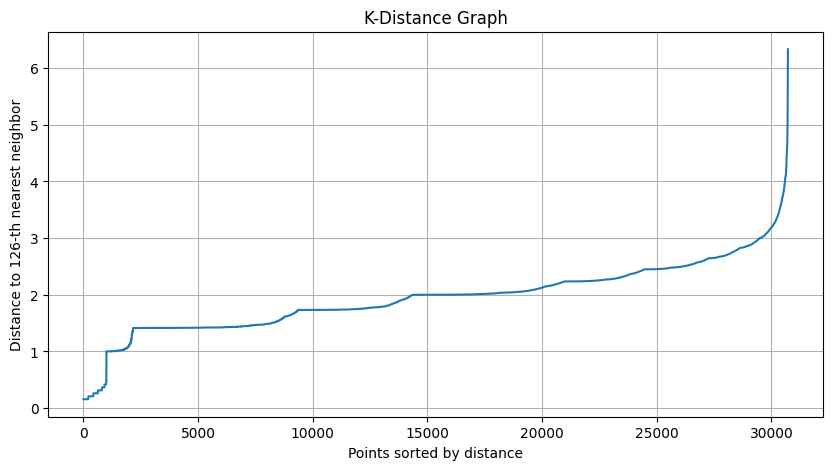

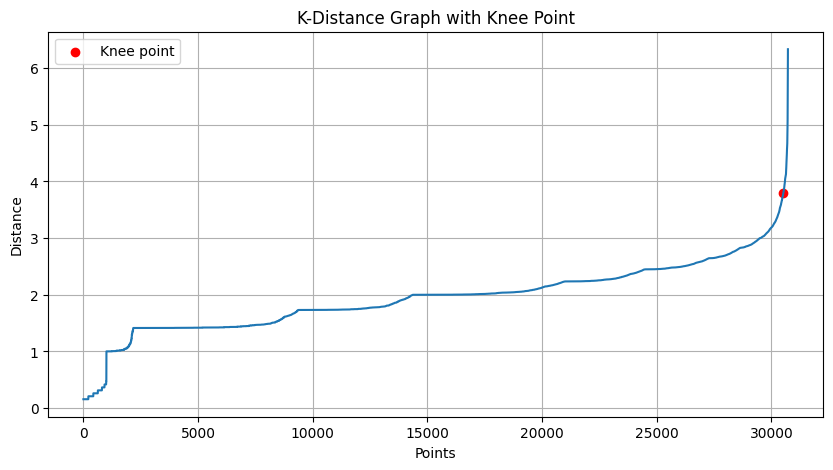

In [130]:
adult_processed, y = preprocess(adult_df, 'income')
# adult_pca, pca_model = apply_pca(adult_processed)

# Assuming k is determined as twice the number of dimensions of the PCA output
k = 2 * adult_processed.shape[1]  # Modify based on your specific choice
sorted_distances = plot_k_distance(adult_processed, k)
initial_epsilon = detect_knee_point(sorted_distances)

In [131]:
# Example epsilon and min_samples range for grid search
eps_range = np.linspace(initial_epsilon * 0.8, initial_epsilon * 1.2, 5)
min_samples_values = range(4, k+1, 20)

best_eps, best_min_samples, best_labels = optimize_dbscan_params(adult_processed, eps_range, min_samples_values)
print(f"Optimized Epsilon: {best_eps}, Min Samples: {best_min_samples}")


Testing eps=3.039707576353383, min_samples=4: silhouette=0.3325, clusters=5, noise=10
Testing eps=3.039707576353383, min_samples=24: silhouette=0.3372, clusters=4, noise=25
Testing eps=3.039707576353383, min_samples=44: silhouette=0.3368, clusters=4, noise=37
Testing eps=3.039707576353383, min_samples=64: silhouette=0.3358, clusters=4, noise=58
Testing eps=3.039707576353383, min_samples=84: silhouette=0.3349, clusters=4, noise=77
Testing eps=3.039707576353383, min_samples=104: silhouette=0.3351, clusters=3, noise=203
Testing eps=3.039707576353383, min_samples=124: silhouette=0.3347, clusters=3, noise=208
Testing eps=3.419671023397556, min_samples=4: silhouette=0.3331, clusters=5, noise=2
Testing eps=3.419671023397556, min_samples=24: silhouette=0.3358, clusters=4, noise=8
Testing eps=3.419671023397556, min_samples=44: silhouette=0.3354, clusters=4, noise=9
Testing eps=3.419671023397556, min_samples=64: silhouette=0.3377, clusters=4, noise=11
Testing eps=3.419671023397556, min_samples=8

In [135]:
cluster_labels = dbscan_clustering(adult_processed, 3.7996344704417284 , 4)
print("Cluster Labels:")
print(cluster_labels)

Silhouette:  0.5032604342649377
Cluster Labels:
[0 0 0 ... 0 0 0]


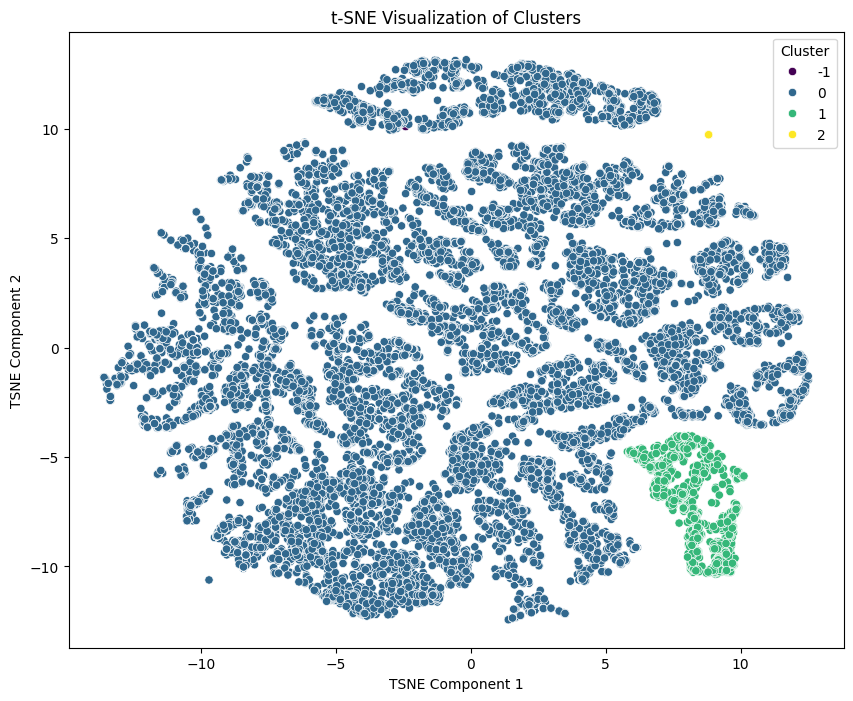

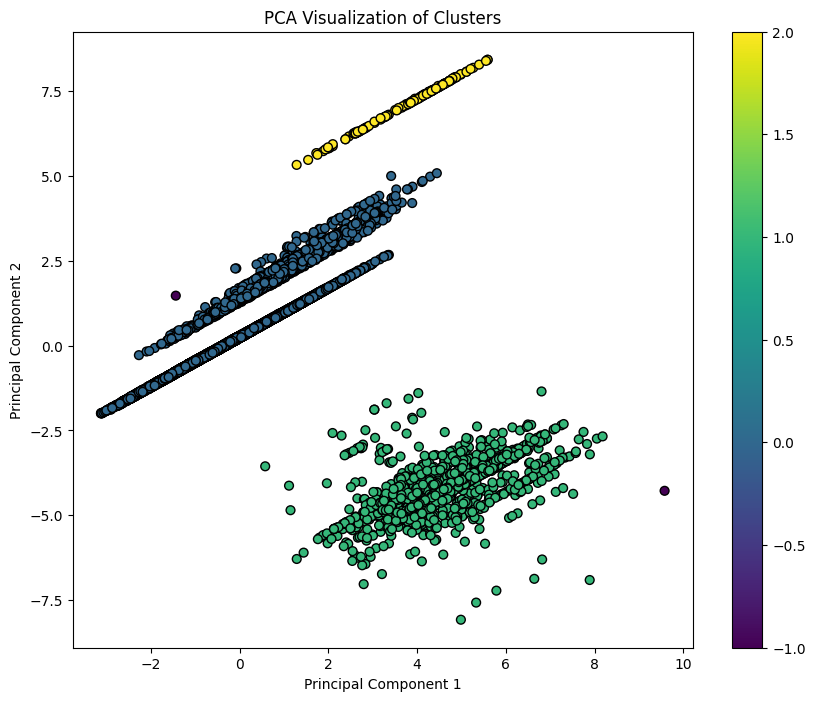

In [136]:
visualize_clusters(adult_processed, cluster_labels)
visualize_clusters_pca(adult_processed, cluster_labels)

Refined Cluster Labels:
[0 0 0 ... 0 0 0]


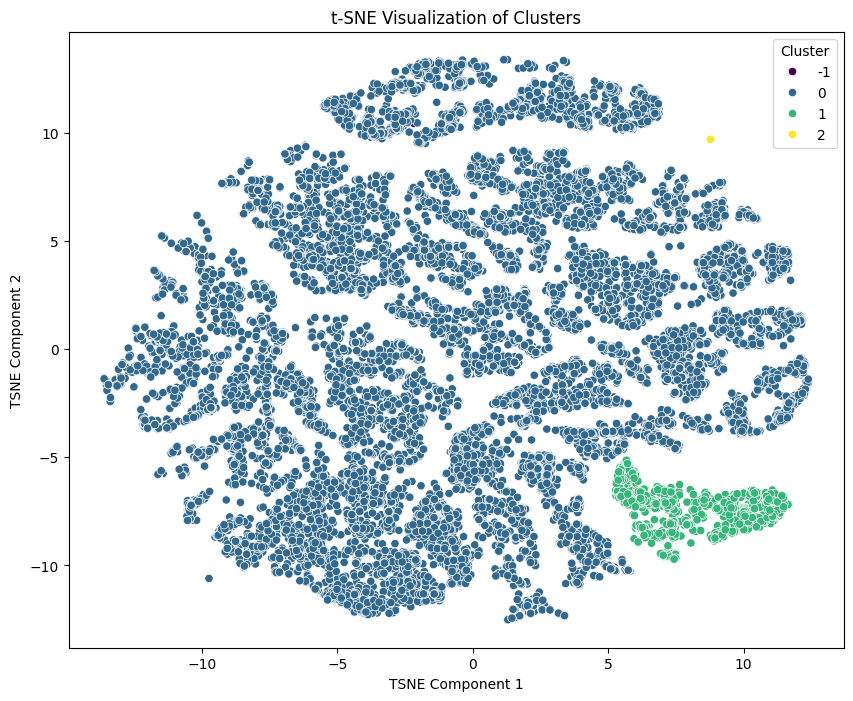

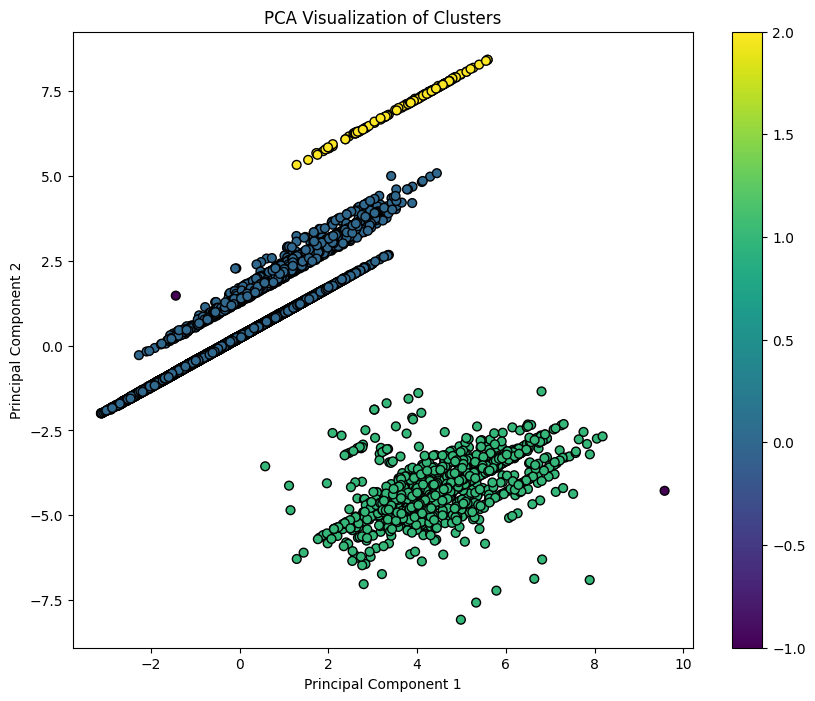

In [137]:
refined_labels = refine_clusters(adult_processed, cluster_labels, best_eps, best_min_samples)
print("Refined Cluster Labels:")
print(refined_labels)
visualize_clusters(adult_processed, refined_labels)
visualize_clusters_pca(adult_processed, refined_labels)


## Cluster Analysis

In [138]:
adult_processed['Cluster'] = refined_labels

# Calculate the mean or median of the features for each cluster
cluster_descriptions = adult_processed.groupby('Cluster').mean()  # or .median()

cluster_descriptions.to_csv('adult_clusters.csv')

In [149]:
stats = descriptive_stats(adult_processed, 'Cluster')
#print("Descriptive Statistics:\n", stats)

stats.to_csv('descriptive_statistics_adult.csv')
anova_results = perform_anova_on_all_numeric(adult_processed, 'Cluster')

# Chi-squared test on one-hot encoded categorical features
chi_squared_results = chi_squared_test(adult_processed, adult_processed.columns, 'Cluster')
print("Chi-squared test results:", chi_squared_results)


Chi-squared test results: {'education-num': {'chi2': 1429.3589975685086, 'p-value': 4.151348332129917e-270}, 'capital-gain': {'chi2': 38538.53127414948, 'p-value': 0.0}, 'capital-loss': {'chi2': 38395.20277731487, 'p-value': 0.0}, 'positive_capital_gain': {'chi2': 1823.463723178682, 'p-value': 0.0}, 'positive_capital_loss': {'chi2': 30713.959979409516, 'p-value': 0.0}, 'age_education_interaction': {'chi2': 25561.939313686256, 'p-value': 0.0}, 'workclass_Local-gov': {'chi2': 10.726775049157064, 'p-value': 0.01329888408060965}, 'workclass_Never-worked': {'chi2': 0.3889507821611344, 'p-value': 0.9425154272386378}, 'workclass_Private': {'chi2': 71.89179655221241, 'p-value': 1.6791679448203077e-15}, 'workclass_Self-emp-inc': {'chi2': 192.52984429773986, 'p-value': 1.7342152862869293e-41}, 'workclass_Self-emp-not-inc': {'chi2': 32.28019012520046, 'p-value': 4.5680612905841797e-07}, 'workclass_State-gov': {'chi2': 15.709911795276541, 'p-value': 0.0013003231908595065}, 'workclass_Without-pay':

In [150]:
anova_results

{'education-num': {'F-value': 126.28884739816817,
  'P-value': 2.6485796053945774e-81},
 'capital-gain': {'F-value': 77333.23071326433, 'P-value': 0.0},
 'capital-loss': {'F-value': 254489.36269638382, 'P-value': 0.0},
 'positive_capital_gain': {'F-value': 646.0859439353119, 'P-value': 0.0},
 'positive_capital_loss': {'F-value': 28489184.924828973, 'P-value': 0.0},
 'age_education_interaction': {'F-value': 168.48100213585195,
  'P-value': 2.4470889994441505e-108}}

# Example - CMC

In [ ]:
file_path = 'cmc.data'
columns = [
    'wife_age', 'wife_edu', 'husband_edu', 'num_children', 'wife_religion', 'wife_working', 'husband_occupation',
    'standard_of_living_index', 'media_exposure', 'contraceptive_method'
]
cmc_df = pd.read_csv(file_path, names=columns, na_values="?", skipinitialspace=True)

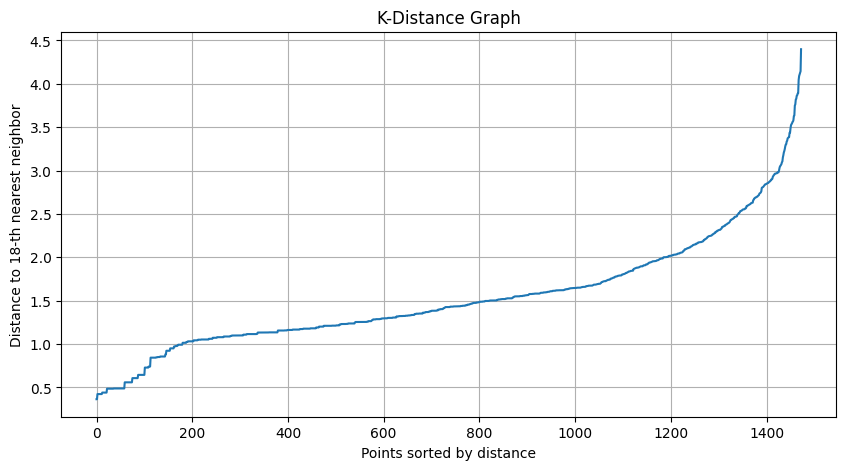

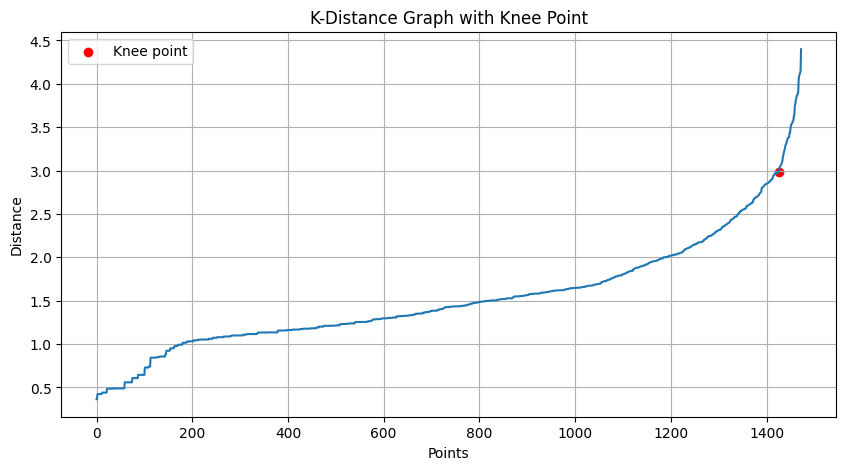

In [ ]:
cmc_processed, y = preprocess(cmc_df, 'contraceptive_method')
# cmc_pca, pca_model = apply_pca(cmc_processed)

# Assuming k is determined as twice the number of dimensions of the PCA output
k = 2 * cmc_processed.shape[1]  # Modify based on your specific choice
sorted_distances = plot_k_distance(cmc_processed, k)
initial_epsilon = detect_knee_point(sorted_distances)

In [ ]:
# Example epsilon and min_samples range for grid search
eps_range = np.linspace(initial_epsilon, initial_epsilon * 1.2, 5)
min_samples_values = range(2, 9, 2)

best_eps, best_min_samples, best_labels = optimize_dbscan_params(cmc_processed, eps_range, min_samples_values)
print(f"Optimized Epsilon: {best_eps}, Min Samples: {best_min_samples}")


Testing eps=2.9813011642879, min_samples=2: silhouette=0.3419, clusters=2, noise=3
Testing eps=2.9813011642879, min_samples=4: silhouette=0.3419, clusters=2, noise=3
Testing eps=2.9813011642879, min_samples=6: silhouette=0.3096, clusters=3, noise=4
Testing eps=2.9813011642879, min_samples=8: silhouette=0.3212, clusters=2, noise=10
Testing eps=3.130366222502295, min_samples=2: silhouette=0.3405, clusters=2, noise=1
Testing eps=3.130366222502295, min_samples=4: silhouette=0.3405, clusters=2, noise=1
Testing eps=3.130366222502295, min_samples=6: silhouette=0.3405, clusters=2, noise=1
Testing eps=3.130366222502295, min_samples=8: silhouette=0.3205, clusters=2, noise=5
Testing eps=3.2794312807166897, min_samples=8: silhouette=0.2998, clusters=2, noise=1
Best Parameters: eps=3.130366222502295, min_samples=2, score=1.0865
Clusters found: 2, Noise: 1
Optimized Epsilon: 3.130366222502295, Min Samples: 2


In [ ]:
cluster_labels = dbscan_clustering(cmc_processed, best_eps, 4)
print("Cluster Labels:")
print(cluster_labels)

Cluster Labels:
[0 0 0 ... 0 0 0]


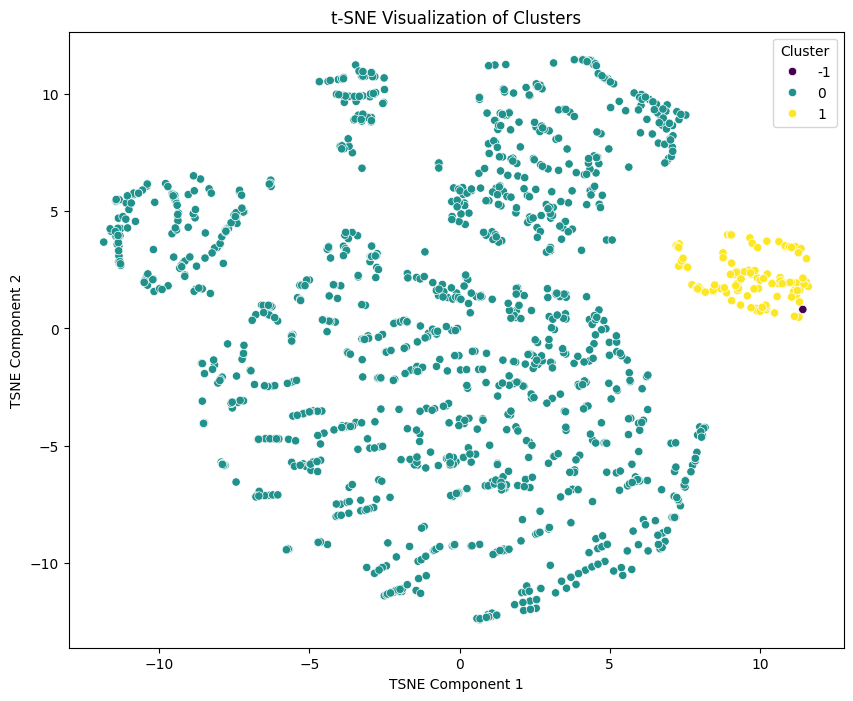

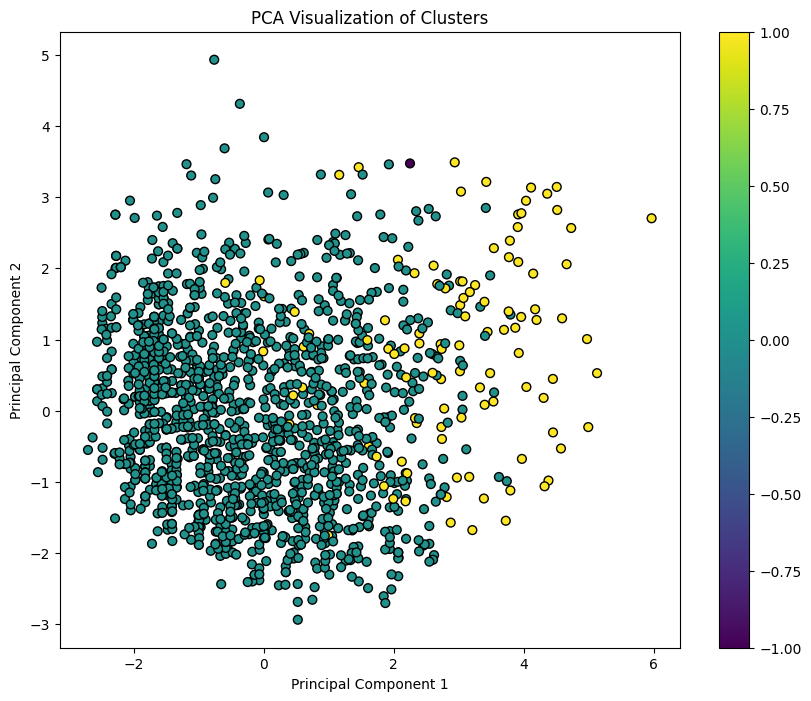

In [ ]:
visualize_clusters(cmc_processed, cluster_labels)
visualize_clusters_pca(cmc_processed, cluster_labels)

Refined Cluster Labels:
[0 0 0 ... 0 0 0]


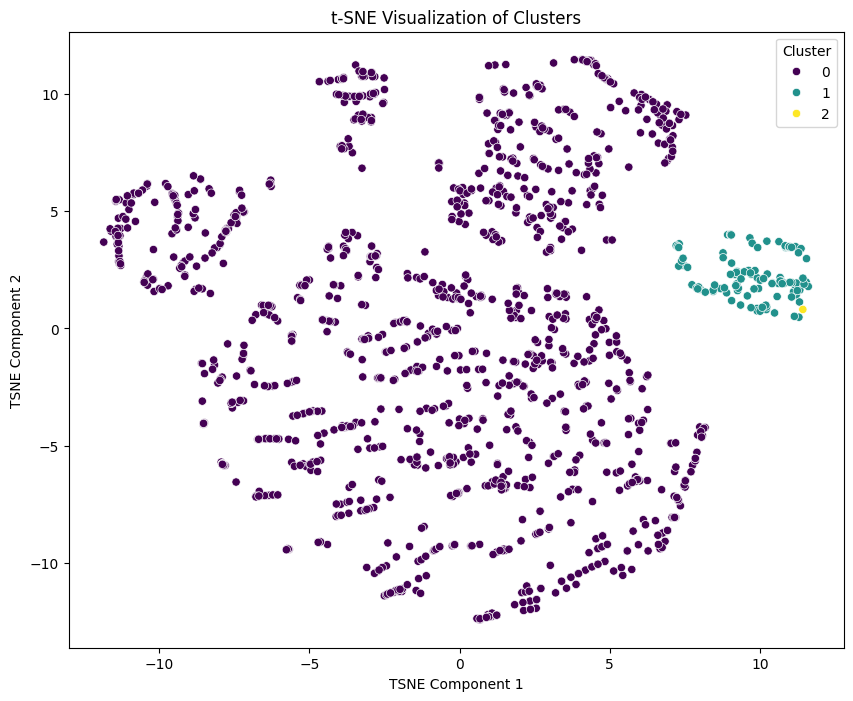

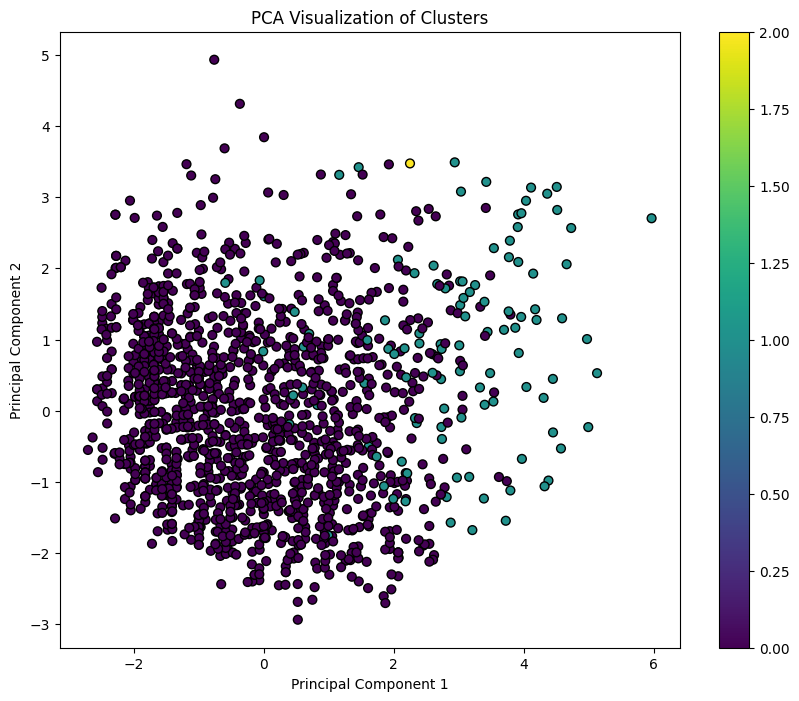

In [ ]:
refined_labels = refine_clusters(cmc_processed, cluster_labels, best_eps, best_min_samples)
print("Refined Cluster Labels:")
print(refined_labels)
visualize_clusters(cmc_processed, refined_labels)
visualize_clusters_pca(cmc_processed, refined_labels)


In [ ]:
cmc_processed['Cluster'] = refined_labels

# Calculate the mean or median of the features for each cluster
cluster_descriptions = cmc_processed.groupby('Cluster').mean()  # or .median()

# Display the cluster centroids
print(cluster_descriptions)
cat_cols = cmc_processed.select_dtypes(include=['object', 'category']).columns

# For categorical features, you can look at mode or counts
for column in cat_cols:
    print(f"\nFeature: {column}")
    print(cmc_processed.groupby('Cluster')[column].value_counts(normalize=True))


         wife_age  wife_edu  husband_edu  num_children  wife_religion  \
Cluster                                                                 
0       -0.032030  0.095006     0.081609     -0.037783      -0.017030   
1        0.393877 -1.182013    -1.037166      0.446801       0.237181   
2        1.150428 -1.930310     0.698793      3.282212      -2.386515   

         wife_working  husband_occupation  standard_of_living_index  \
Cluster                                                               
0           -0.000517           -0.032205                  0.071056   
1            0.001175            0.408214                 -0.886653   
2            0.578134           -0.159403                 -1.161823   

         media_exposure  
Cluster                  
0             -0.282687  
1              3.537480  
2              3.537480  


# CMC ARM

In [ ]:
cmc_transactions = dataframe_to_transactions(cmc_processed)

In [ ]:
cmc_transactions[0]

['workclass_State-gov',
 'education_Bachelors',
 'marital-status_Never-married',
 'relationship_Not-in-family',
 'race_White',
 'sex_Male',
 'native_country_aggregated_United-States',
 'age_binned_36-45',
 'hours_per_week_binned_41-50']